# 1. Importing Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation,BatchNormalization, MaxPool2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

# 2. Loading and Exploring Data

In [31]:
data=pd.read_csv("./Dataset/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [32]:
data.shape

(35887, 3)

In [33]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Check unique values in the 'Usage' column

In [34]:
np.unique(data["Usage"].values.ravel())
print("Eğitim setinde örnek sayısı: %d"%(len(data[data["Usage"]=="Training"])))

Eğitim setinde örnek sayısı: 28709


# 3. Data Preprocessing


In [35]:
train_data=data[data.Usage=="Training"]

In [36]:
train_pixels=train_data.pixels.str.split(" ").tolist()

In [37]:
train_pixels=pd.DataFrame(train_pixels,dtype=int)
train_images=train_pixels.values
train_images=train_images.astype(float)

train_images.shape

C:\Users\gbara\AppData\Local\Temp\ipykernel_3432\3163919778.py:1: FutureWarning: Could not cast to int32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  train_pixels=pd.DataFrame(train_pixels,dtype=int)


(28709, 2304)

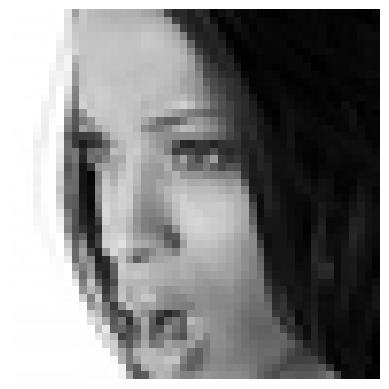

In [38]:
def show(img):
    show_image=img.reshape(48,48)
    plt.axis('off')
    plt.imshow(show_image,cmap='gray')
show(train_images[28654])

In [39]:
train_labels_flat=train_data['emotion'].values.ravel()
train_labels_count=np.unique(train_labels_flat).shape[0]
train_labels_count

7

In [40]:
def dense_to_one_hot(labels_dense,num_classes):
    num_labels=labels_dense.shape[0]
    index_offset=np.arange(num_labels)*num_classes
    labels_one_hot=np.zeros((num_labels,num_classes))
    labels_one_hot.flat[index_offset+labels_dense.ravel()]=1
    return labels_one_hot

In [41]:
y_train=dense_to_one_hot(train_labels_flat,train_labels_count)
y_train=y_train.astype(np.uint8)

In [42]:
y_train.shape

(28709, 7)

In [43]:
np.unique(data["Usage"].values.ravel())
print("test setinde örnek sayısı: %d"%(len(data[data['Usage']=='PublicTest'])))

test setinde örnek sayısı: 3589


In [44]:
test_data=data[data.Usage=="PublicTest"]
test_pixels=test_data.pixels.str.split(" ").tolist()

test_pixels=pd.DataFrame(test_pixels,dtype=int)
test_images=test_pixels.values
test_images=test_images.astype(float)

test_images.shape

C:\Users\gbara\AppData\Local\Temp\ipykernel_3432\1198511829.py:4: FutureWarning: Could not cast to int32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  test_pixels=pd.DataFrame(test_pixels,dtype=int)


(3589, 2304)

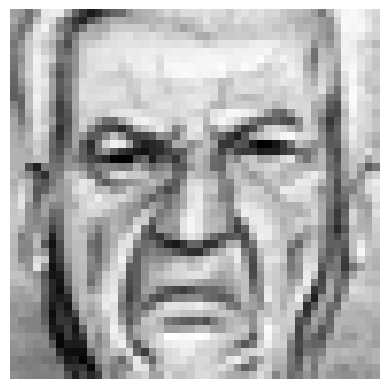

In [45]:
show(test_images[1242])

In [46]:
test_labels_flat=test_data['emotion'].values.ravel()
test_labels_count=np.unique(test_labels_flat).shape[0]

y_test=dense_to_one_hot(test_labels_flat,test_labels_count)
y_test=y_test.astype(np.uint8)
y_test.shape

(3589, 7)

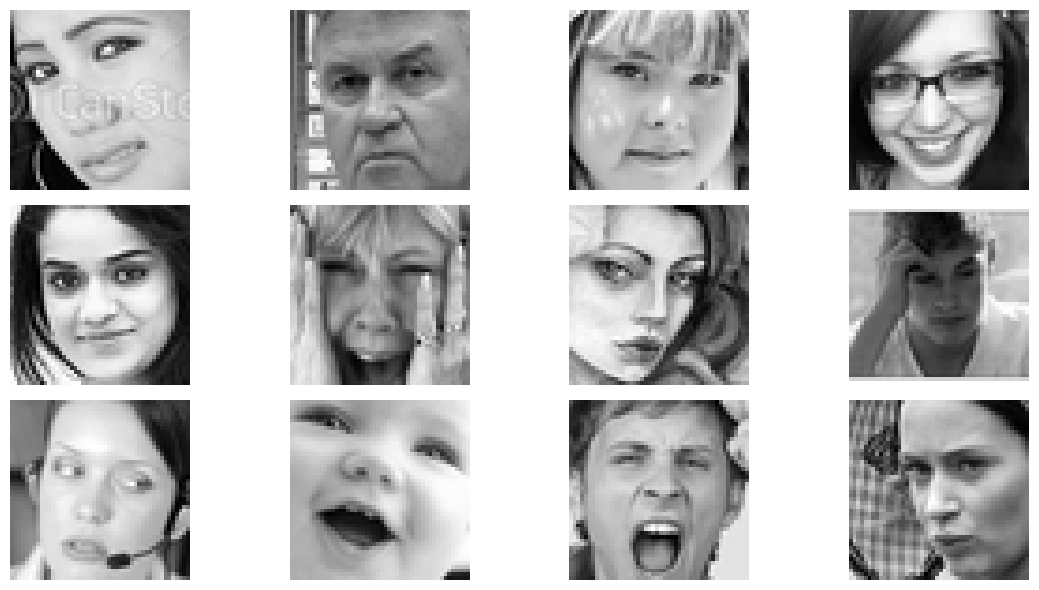

In [47]:
plt.figure(0,figsize=(12,6))
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.axis('off')
    
    image=test_images[i].reshape(48,48)
    plt.imshow(image,cmap='gray')
plt.tight_layout()
plt.show()

# 4. Building the Convolutional Neural Network (CNN) Model

In [48]:
# 5 katman olsun
model=Sequential()
#1. Katman
model.add(Conv2D(64,3,data_format='channels_last',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2.katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.6))

#3.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#4.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
#5.Katman

model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.6))

#Tam Bağlantı Katmanı(Vektörizasyon)
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

#Çıkış katmanı
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)       

In [49]:
x_train=train_images.reshape(-1,48,48,1)
x_test=test_images.reshape(-1,48,48,1)

print(x_train.shape)
print(x_test.shape)


(28709, 48, 48, 1)
(3589, 48, 48, 1)


In [50]:
print(y_train.shape)
print(y_test.shape)


(28709, 7)
(3589, 7)


# 6. Training the Model

In [51]:
# en başarılı ağırlıkları kaydet
checkpointer=ModelCheckpoint(filepath='data/face_model.h5',verbose=1,save_best_only=True)
epochs=5
batchSize=100

hist=model.fit(x_train,y_train,epochs=epochs,
               shuffle=True,
               batch_size=batchSize,
               validation_data=(x_test,y_test),
               callbacks=[checkpointer],verbose=2)

#Saving the Model
model_json=model.to_json()
with open('data/face_model.json',"w") as json_file:
  json_file.write(model_json)


Epoch 1/5

Epoch 1: val_loss improved from inf to 1.61160, saving model to data\face_model.h5
288/288 - 152s - loss: 1.9532 - accuracy: 0.2634 - val_loss: 1.6116 - val_accuracy: 0.3617 - 152s/epoch - 527ms/step
Epoch 2/5


C:\Users\gbara\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.61160 to 1.60960, saving model to data\face_model.h5
288/288 - 144s - loss: 1.6532 - accuracy: 0.3499 - val_loss: 1.6096 - val_accuracy: 0.3840 - 144s/epoch - 499ms/step
Epoch 3/5

Epoch 3: val_loss improved from 1.60960 to 1.60912, saving model to data\face_model.h5
288/288 - 144s - loss: 1.5478 - accuracy: 0.3982 - val_loss: 1.6091 - val_accuracy: 0.3965 - 144s/epoch - 500ms/step
Epoch 4/5

Epoch 4: val_loss improved from 1.60912 to 1.38795, saving model to data\face_model.h5
288/288 - 143s - loss: 1.4704 - accuracy: 0.4308 - val_loss: 1.3879 - val_accuracy: 0.4661 - 143s/epoch - 495ms/step
Epoch 5/5

Epoch 5: val_loss improved from 1.38795 to 1.31450, saving model to data\face_model.h5
288/288 - 141s - loss: 1.4117 - accuracy: 0.4553 - val_loss: 1.3145 - val_accuracy: 0.4937 - 141s/epoch - 490ms/step


# 8. Visualizing Training Results

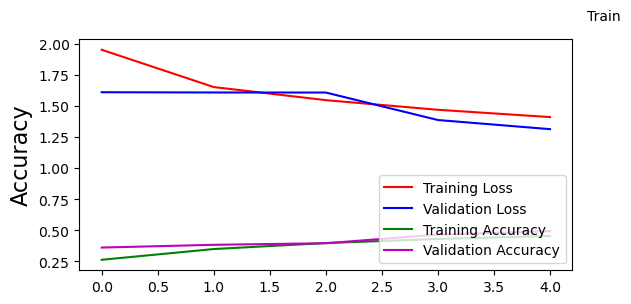

In [52]:


import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.suptitle("Train",fontsize=10)
plt.ylabel("Loss",fontsize=16)
plt.plot(hist.history['loss'],color='r',label='Training Loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,1)
plt.ylabel("Accuracy",fontsize=16)
plt.plot(hist.history['accuracy'],color='g',label='Training Accuracy')
plt.plot(hist.history['val_accuracy'],color='m',label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [54]:
test=data[["emotion","pixels"]][data["Usage"]=="PrivateTest"]
test["pixels"]=test["pixels"].apply(lambda im: np.fromstring(im,sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [55]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [59]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = to_categorical(y_test_private)
print(x_test_private.shape, y_test_private.shape)

(3589, 48, 48, 1) (3589, 7)


In [60]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu: ", score)

PrivateTest üzerindeki doğruluk durumu:  [1.3074474334716797, 0.4928949475288391]


# 9. Testing the Model on New Dataa

In [61]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [68]:
# en iyi ağırlıkları yükle
model_best=load_model('data/face_model.h5')

# 10. Making Predictions

In [102]:
from keras.preprocessing import image

image_path = 'image/mutlu.jpg'

test_image_original = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image_original)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


1/1 [==============================] - 0s 17ms/step


array([[0.32343388, 0.05754051, 0.2708591 , 0.10293218, 0.11513896,
        0.08492496, 0.04517046]], dtype=float32)

# 11. Visualizing Results

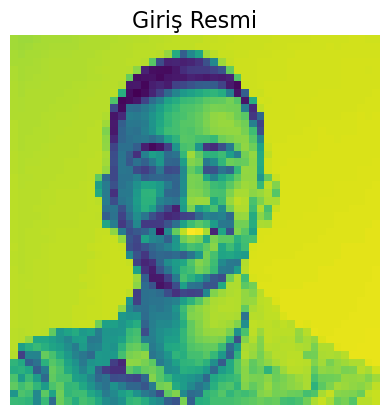

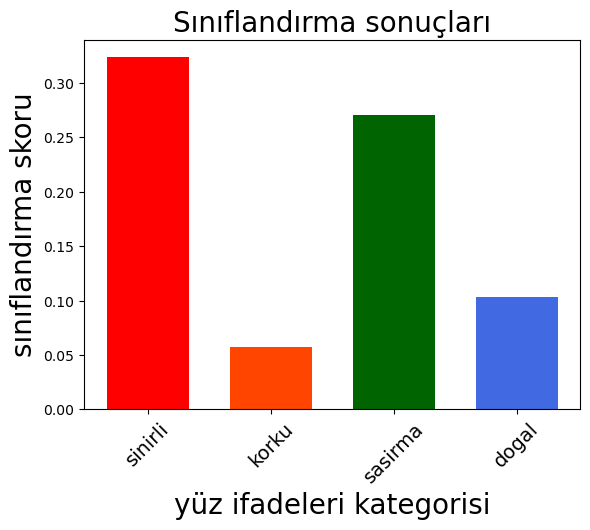

sınıflandırma sonucu en yüksek oranla:  sinirli


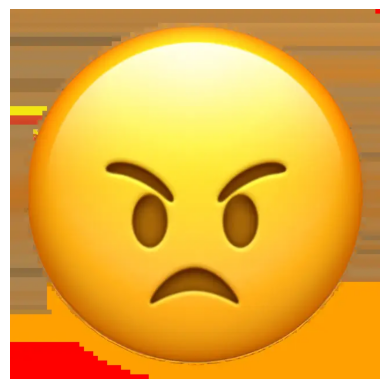

In [104]:
class_names=['sinirli','korku','sasirma','dogal']
ind=0.1+0.6*np.arange(len(class_names))
width=0.4
color_list=['red','orangered','darkgreen','royalblue','navy']
plt.imshow(test_image_original)
plt.title('Giriş Resmi',fontsize=16)
plt.axis('off')
plt.show()

for i in range(len(class_names)):
    plt.bar(ind[i],results[0][i],width,color=color_list[i])
plt.title("Sınıflandırma sonuçları",fontsize=20)
plt.xlabel("yüz ifadeleri kategorisi",fontsize=20)
plt.ylabel("sınıflandırma skoru",fontsize=20)
plt.xticks(ind,class_names,rotation=45,fontsize=14)
plt.show()

print("sınıflandırma sonucu en yüksek oranla: ",class_names[np.argmax(results)])
# En yüksek skorlu duyguya karşılık emoji çizdirme

emojis_img=image.load_img('emojis/%s.jpg'%str(class_names[np.argmax(results)]))
plt.imshow(emojis_img)
plt.axis('off')
plt.show()